# ANN, excluding Val-epitopes

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import torch

2025-01-13 18:23:31.238964: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 18:23:31.246530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 18:23:31.254872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 18:23:31.257345: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 18:23:31.263746: I tensorflow/core/platform/cpu_feature_guar

In [8]:
def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

torch.cuda.empty_cache()
print_gpu_memory()

import gc

# Invoke garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

Allocated memory: 0.00 MB
Cached memory: 0.00 MB


## dataset

In [2]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# shuffle rows
df = df.sample(frac=1)
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_C,has_I,has_L,has_K,has_F,has_P,has_S,has_T,has_Y,has_V
2052883,EVGEPYGVWGGLSES,0,17.333333,0.829333,8.506667,0.125400,2.787333,0.0,0.470,9.0,...,0,0,1,0,0,1,1,0,1,1
1239758,DDEEDDEEDDEEDDEEDDE,1,-43.631579,0.464737,12.668421,0.126789,3.253684,-55.0,0.460,13.0,...,0,0,0,0,0,0,0,0,0,0
521717,ITANRVLHC,0,37.888889,0.896667,7.855556,0.161000,3.418889,41.0,0.610,8.1,...,1,1,1,0,0,0,0,1,0,1
2303822,YYKCLVLGLV,0,59.500000,1.328000,6.470000,0.178100,3.814000,69.5,1.425,5.9,...,1,0,1,1,0,0,0,0,1,1
2772923,FSLPSVDGQKRY,1,14.833333,0.923333,8.575000,0.163667,3.575833,-5.0,0.875,9.1,...,0,0,1,1,1,1,1,0,1,1


In [3]:
%load_ext autoreload
%autoreload 2

from seq.my_ann import MyAnn

## filter I: without Val

In [4]:
# keep epitopes without Val
feature = 'has_V'
print('entire data:', df.shape)
print('epitopes without Val:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Val:', df[(df[feature]==1) & (df['label']==1)].shape)
sub_df = df[~((df[feature]==1) & (df['label']==1))]
sub_df = sub_df.drop([feature,], axis=1)
print('filtered data:', sub_df.shape)

entire data: (3458238, 50)
epitopes without Val: (757565, 50)
epitopes having Val: (1107677, 50)
filtered data: (2350561, 49)


In [5]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2350561, 47) float16
y: (2350561,) float16
labels: Counter({0.0: 1592996, 1.0: 757565})
train data: (1316313, 47) (1316313,)
validate data: (564135, 47) (564135,)
test data (470113, 47) (470113,)


In [6]:
# train model
c.declare_model()
c.train(epochs=10)

I0000 00:00:1736810656.735728   56102 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736810656.736525   56102 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736810656.736620   56102 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736810656.737699   56102 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,921 (288.75 KB)

 Trainable params: 73,921 (288.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


I0000 00:00:1736810658.167043   56257 service.cc:146] XLA service 0x725e7c0056a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736810658.167071   56257 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-13 18:24:18.190657: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-13 18:24:18.278818: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


   76/41135 ━━━━━━━━━━━━━━━━━━━━ 1:26 2ms/step - accuracy: 0.6701 - auc: 0.6556 - loss: 0.6046 - mse: 0.2088 - precision: 0.4901 - recall: 0.2658 

I0000 00:00:1736810659.211573   56257 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41135/41135 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accuracy: 0.7660 - auc: 0.8468 - loss: 0.4262 - mse: 0.1475 - precision: 0.6392 - recall: 0.6312 - val_accuracy: 0.7829 - val_auc: 0.8659 - val_loss: 0.4056 - val_mse: 0.1393 - val_precision: 0.6717 - val_recall: 0.6408
Epoch 2/10
41135/41135 ━━━━━━━━━━━━━━━━━━━━ 85s 2ms/step - accuracy: 0.7836 - auc: 0.8651 - loss: 0.4069 - mse: 0.1395 - precision: 0.6567 - recall: 0.6904 - val_accuracy: 0.7902 - val_auc: 0.8740 - val_loss: 0.3975 - val_mse: 0.1359 - val_precision: 0.6518 - val_recall: 0.7518
Epoch 3/10
41135/41135 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - accuracy: 0.7895 - auc: 0.8709 - loss: 0.4006 - mse: 0.1368 - precision: 0.6617 - recall: 0.7106 - val_accuracy: 0.7943 - val_auc: 0.8769 - val_loss: 0.3929 - val_mse: 0.1339 - val_precision: 0.6710 - val_recall: 0.7122
Epoch 4/10
41135/41135 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 0.7918 - auc: 0.8726 - loss: 0.3987 - mse: 0.1359 - precision: 0.6649 - recall: 0.7144 - val_accuracy: 0.

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.773027,0.854348,0.418032,0.144329,0.647228,0.649954,0.782912,0.865936,0.405624,0.139313,0.671691,0.640804
1,0.785450,0.866757,0.405058,0.138716,0.657552,0.697493,0.790233,0.874043,0.397497,0.135859,0.651847,0.751812
2,0.789858,0.871044,0.400408,0.136661,0.661892,0.711234,0.794340,0.876944,0.392891,0.133950,0.670984,0.712231
3,0.792011,0.873068,0.397987,0.135636,0.664956,0.714726,0.795115,0.877535,0.392294,0.133396,0.674127,0.707295
4,0.792946,0.874148,0.396825,0.135101,0.665949,0.717328,0.797346,0.879569,0.389991,0.132607,0.678243,0.708332
5,0.793892,0.875056,0.395687,0.134639,0.667330,0.718735,0.798009,0.880013,0.389285,0.132402,0.679631,0.708184
6,0.794920,0.875765,0.394885,0.134287,0.668887,0.720091,0.796653,0.880132,0.391002,0.133024,0.663210,0.752070
7,0.795278,0.876387,0.394215,0.134004,0.669726,0.719622,0.797481,0.880628,0.388033,0.131910,0.670008,0.734451
8,0.795552,0.876577,0.394054,0.133897,0.669727,0.721291,0.798431,0.880563,0.387821,0.131721,0.672455,0.732408
9,0.796028,0.877052,0.393524,0.133654,0.670442,0.721941,0.798273,0.881110,0.387528,0.131647,0.681095,0.705510


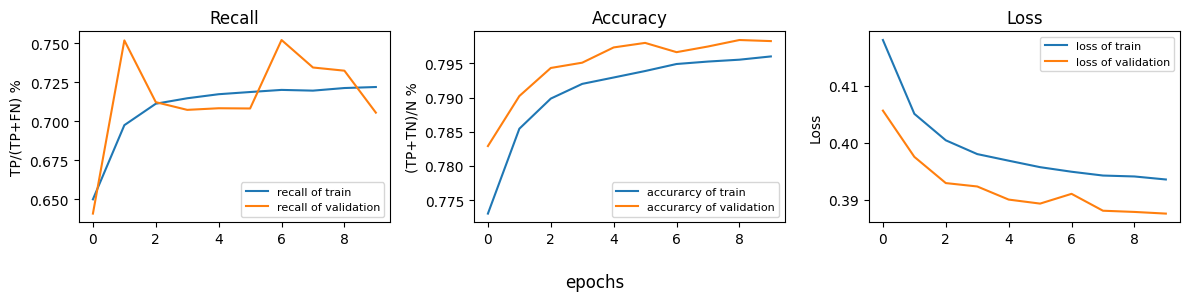

In [7]:
# evaluate model
c.plot_acc_recall()

14692/14692 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7980 - auc: 0.8806 - loss: 0.3880 - mse: 0.1319 - precision: 0.6794 - recall: 0.7074
{'accuracy': 0.7981060147285461, 'auc': 0.8807337880134583, 'loss': 0.38750284910202026, 'mse': 0.1316719949245453, 'precision': 0.6790510416030884, 'recall': 0.7061581015586853}
14692/14692 ━━━━━━━━━━━━━━━━━━━━ 6s 374us/step
[[0.6544089 ]
 [0.19246195]
 [0.        ]]


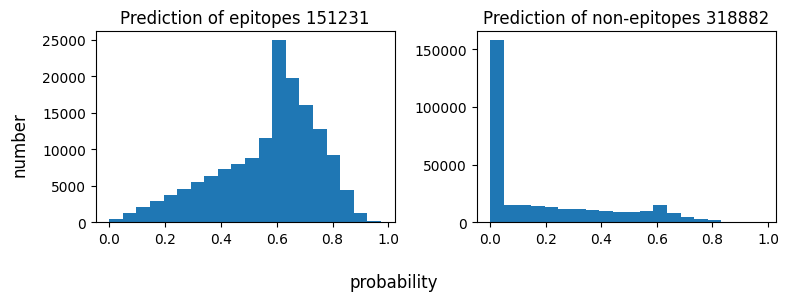

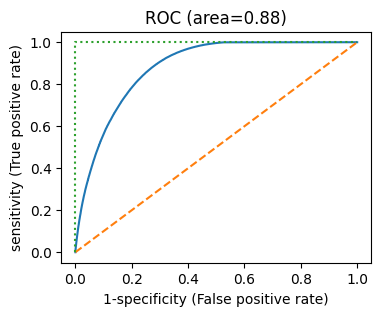

In [8]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [10]:
# save entire model
c.save_model('../models/epitopes_ann_notVal.keras')

<Sequential name=sequential, built=True>

## filter II: having Val

In [11]:
# keep epitopes contain Val
feature = 'has_V'
print('entire data:', df.shape)
print('epitopes without Val:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Val:', df[(df[feature]==1) & (df['label']==1)].shape)
sub_df = df[~((df[feature]==0) & (df['label']==1))]
sub_df = sub_df.drop([feature,], axis=1)
print('filtered data:', sub_df.shape)

entire data: (3458238, 50)
epitopes without Val: (757565, 50)
epitopes having Val: (1107677, 50)
filtered data: (2700673, 49)


In [12]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2700673, 47) float16
y: (2700673,) float16
labels: Counter({0.0: 1592996, 1.0: 1107677})
train data: (1512376, 47) (1512376,)
validate data: (648162, 47) (648162,)
test data (540135, 47) (540135,)


In [13]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,921 (288.75 KB)

 Trainable params: 73,921 (288.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
47262/47262 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - accuracy: 0.7716 - auc: 0.8585 - loss: 0.4238 - mse: 0.1460 - precision: 0.6782 - recall: 0.8425 - val_accuracy: 0.7872 - val_auc: 0.8733 - val_loss: 0.4055 - val_mse: 0.1388 - val_precision: 0.7000 - val_recall: 0.8430
Epoch 2/10
47262/47262 ━━━━━━━━━━━━━━━━━━━━ 85s 2ms/step - accuracy: 0.7837 - auc: 0.8702 - loss: 0.4097 - mse: 0.1404 - precision: 0.6882 - recall: 0.8630 - val_accuracy: 0.7909 - val_auc: 0.8772 - val_loss: 0.4004 - val_mse: 0.1366 - val_precision: 0.6922 - val_recall: 0.8833
Epoch 3/10
47262/47262 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.7879 - auc: 0.8739 - loss: 0.4056 - mse: 0.1385 - precision: 0.6939 - recall: 0.8657 - val_accuracy: 0.7933 - val_auc: 0.8785 - val_loss: 0.3995 - val_mse: 0.1361 - val_precision: 0.6996 - val_recall: 0.8702
Epoch 4/10
47262/47262 ━━━━━━━━━━━━━━━━━━━━ 97s 2ms/step - accuracy: 0.7902 - auc: 0.8758 - loss: 0.4034 - mse: 0.1375 - precision: 0.6978 - recall: 0.8621 - 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.777612,0.864651,0.415871,0.142976,0.681923,0.857864,0.787204,0.873296,0.405525,0.138771,0.699955,0.843003
1,0.784978,0.871390,0.408314,0.139759,0.689919,0.864007,0.790884,0.877158,0.400388,0.136587,0.692250,0.883276
2,0.788461,0.874108,0.405265,0.138385,0.694553,0.864252,0.793348,0.878510,0.399523,0.136143,0.699626,0.870220
3,0.790100,0.875828,0.403310,0.137503,0.697585,0.861758,0.795778,0.881162,0.395301,0.134397,0.701508,0.874715
4,0.791218,0.876729,0.402362,0.137053,0.699221,0.861473,0.796991,0.882025,0.394564,0.134050,0.704854,0.869615
5,0.791842,0.877427,0.401491,0.136682,0.700267,0.860915,0.797946,0.882746,0.393389,0.133565,0.716358,0.840665
6,0.792506,0.878039,0.400774,0.136367,0.701404,0.860263,0.797950,0.882822,0.395053,0.134122,0.718625,0.834599
7,0.792505,0.878287,0.400503,0.136252,0.701534,0.859864,0.797879,0.883253,0.393483,0.133571,0.702392,0.880875
8,0.793409,0.878781,0.399887,0.135980,0.703013,0.859215,0.795101,0.883252,0.395676,0.134480,0.692549,0.900756
9,0.793287,0.878829,0.399874,0.135945,0.703141,0.858316,0.798933,0.883275,0.392498,0.133154,0.715571,0.846799


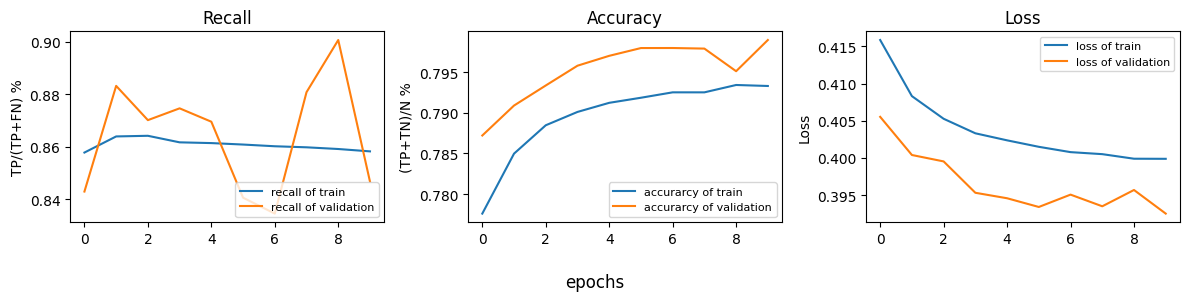

In [14]:
# evaluate model
c.plot_acc_recall()

16880/16880 ━━━━━━━━━━━━━━━━━━━━ 16s 971us/step - accuracy: 0.7989 - auc: 0.8830 - loss: 0.3927 - mse: 0.1332 - precision: 0.7150 - recall: 0.8472
{'accuracy': 0.7986096143722534, 'auc': 0.8828876614570618, 'loss': 0.3928225636482239, 'mse': 0.13330036401748657, 'precision': 0.7143847346305847, 'recall': 0.8474242687225342}
16880/16880 ━━━━━━━━━━━━━━━━━━━━ 6s 364us/step
[[4.3213153e-01]
 [8.5332906e-01]
 [2.3702669e-23]]


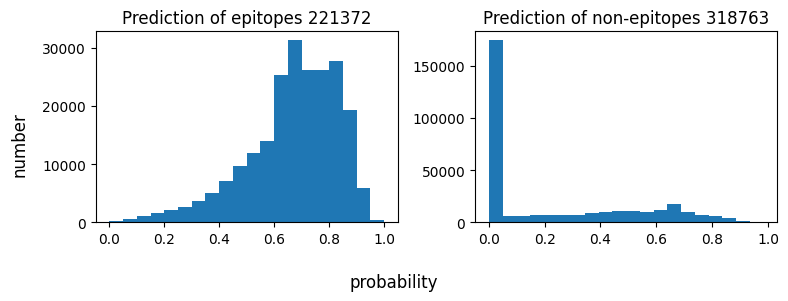

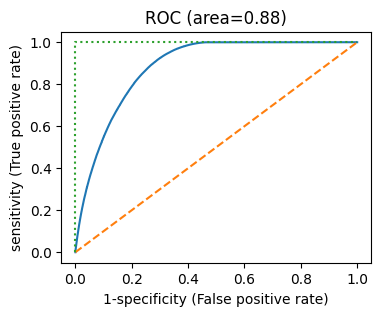

In [15]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [16]:
# save entire model
c.save_model('../models/epitopes_ann_hasVal.keras')

<Sequential name=sequential_1, built=True>